In [1]:
import torch
import numpy as np
from pathlib import Path

from lib.train_dataclasses import TrainConfig
from lib.train_dataclasses import TrainRun
from lib.train_dataclasses import TrainEval
from lib.train_dataclasses import OptimizerConfig
from lib.train_dataclasses import ComputeConfig
from lib.metric import create_metric

from experiments.weather.models.swin_hp_pangu import SwinHPPanguConfig

from lib.ddp import ddp_setup
from lib.ensemble import create_ensemble_config
from lib.ensemble import create_ensemble
from lib.ensemble import request_ensemble
from lib.ensemble import symlink_checkpoint_files
from lib.ensemble import is_ensemble_serialized

from lib.data_factory import get_factory as get_dataset_factory
from lib.render_psql import add_artifact, has_artifact, add_parameter
from experiments.weather.data import DataHP
from experiments.weather.data import DataHPConfig, Climatology
from lib.serialization import deserialize_model, DeserializeConfig

/nix/store/6nl4glqwylwwd07ivccscix3m1rx9fa3-python3-3.12.7-env/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


[Compute environment] paths: 
[Paths] checkpoints: checkpoints (/home/herden/projects/equivariant-posteriors/experiments/weather/checkpoints)
[Paths] locks: locks (/home/herden/projects/equivariant-posteriors/experiments/weather/locks)
[Paths] distributed_requests: distributed_requests (/home/herden/projects/equivariant-posteriors/experiments/weather/distributed_requests)
[Paths] artifacts: artifacts (/home/herden/projects/equivariant-posteriors/experiments/weather/artifacts)
[Paths] datasets: datasets (/home/herden/projects/equivariant-posteriors/experiments/weather/datasets)
[Compute environment] postgres_host: localhost
[Compute environment] postgres_port: 5431
[Compute environment] postgres_password: herdeherde


In [2]:
device_id = ddp_setup()

No ep torch!


In [3]:
from experiments.weather.persisted_configs.train_nside64 import create_config

In [4]:
ensemble_config = create_ensemble_config(create_config, 1)
train_run = ensemble_config.members[0]

In [5]:
deser_config = DeserializeConfig(
                train_run=ensemble_config.members[0],
                device_id=device_id,
            )
deser_model = deserialize_model(deser_config)
model = deser_model.model
_ = model.eval()

Trying to load /home/herden/projects/equivariant-posteriors/experiments/weather/checkpoints/checkpoint_bb689548079209a4a5e37a91412515bf
checkpoints/checkpoint_bb689548079209a4a5e37a91412515bf


/home/herden/projects/equivariant-posteriors/lib/serialization.py:185: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_epoch = torch.load(checkpoint_path / "epoch")
/hom

In [6]:
ds_rmse = DataHP(train_run.train_config.train_data_config)
dl_rmse = torch.utils.data.DataLoader(
        ds_rmse,
        batch_size=1,
        shuffle=False,
        drop_last=False
    )
batch = next(iter(dl_rmse))

In [7]:
import experiments.weather.data as data
import importlib
importlib.reload(data)

batch.keys()
with torch.no_grad():
    output = model(batch)

In [11]:
xds = data.batch_to_weatherbench2(batch, output, 64, True)

/home/herden/projects/equivariant-posteriors/experiments/weather/data.py:256: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  surface = surface.assign_coords(
/home/herden/projects/equivariant-posteriors/experiments/weather/data.py:256: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Varia

In [12]:
xds.to_zarr("pred.zarr")

In [13]:
xds

<xarray.Dataset> Size: 36MB
Dimensions:                  (time: 1, prediction_timedelta: 1, latitude: 180,
                              longitude: 360, level: 13)
Coordinates:
  * latitude                 (latitude) float64 1kB -90.0 -88.99 ... 88.99 90.0
  * longitude                (longitude) float64 3kB 0.0 1.003 ... 359.0 360.0
  * time                     (time) datetime64[ns] 8B 2007-01-01
  * prediction_timedelta     (prediction_timedelta) timedelta64[ns] 8B 1 days
  * level                    (level) int32 52B 1000 925 850 700 ... 150 100 50
Data variables:
    mean_sea_level_pressure  (time, prediction_timedelta, latitude, longitude) float64 518kB ...
    10m_u_component_of_wind  (time, prediction_timedelta, latitude, longitude) float64 518kB ...
    10m_v_component_of_wind  (time, prediction_timedelta, latitude, longitude) float64 518kB ...
    2m_temperature           (time, prediction_timedelta, latitude, longitude) float64 518kB ...
    geopotential             (time, prediction_timedelta, level, latitude, longitude) float64 7MB ...
    specific_humidity        (time, prediction_timedelta, level, latitude, longitude) float64 7MB ...
    temperature              (time, prediction_timedelta, level, latitude, longitude) float64 7MB ...
    u_component_of_wind      (time, prediction_timedelta, level, latitude, longitude) float64 7MB ...
    v_component_of_wind      (time, prediction_timedelta, level, latitude, longitude) float64 7MB ...

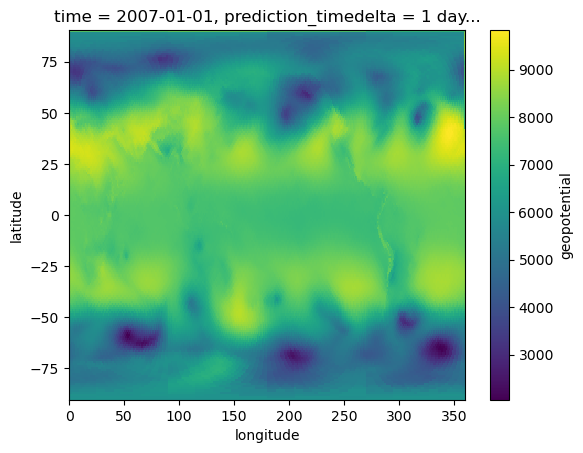

In [22]:
xds.geopotential.isel(time=0, prediction_timedelta=0).sel(level=925).plot()